# Functions

In [1]:
import copy
from scipy.interpolate import interp1d
from skimage.transform import resize

import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

obj_color_idx = {"empty": 0, "water": 5, "detergent": 10,
          "cane-sugar":15, "salt": 20, 
           "chia-seed": 25, "wheat": 30,
          "chickpea": 35, "split-green-pea": 40, "kidney-bean": 45,
          "styrofoam-bead": 50,  "wooden-button": 55, "plastic-bead": 60, 
           "glass-bead":65, "metal-nut-bolt": 70}

modality = 'audio'

all_behaviors = ['1-look', '2-stirring-slow', '3-stirring-fast', '4-stirring-twist', '5-whisk', '6-poke']
all_tools = ['metal-scissor', 'metal-whisk', 'plastic-knife', 'plastic-spoon', 'wooden-chopstick', 'wooden-fork']
all_object_list = ['cane-sugar', 'chia-seed', 'chickpea', 'detergent', 'empty', 'glass-bead', 'kidney-bean', 'metal-nut-bolt', 'plastic-bead', 'salt', 'split-green-pea', 'styrofoam-bead', 'water', 'wheat', 'wooden-button']


def visualize_in_2d(robot_data: dict, method="pca", color_by="object", mark_by=None, token_dim=None, down_ratio = None,
                    tools=all_tools, behaviors=all_behaviors, object_list=all_object_list, modality=modality):
    if behaviors is None:
        behaviors = ['3-stirring-fast']
    from matplotlib.colors import ListedColormap

    # Step 1: Extract data grouped by tools
    all_data = []  # To hold all audio data for each tool
    tool_labels = []  # To hold tool indices for coloring
    behavior_labels = []
    all_labels = []
    all_obj = []
    
    for beh_idx, behavior in enumerate(behaviors):
        behavior_trials = []
        for tool_idx, tool in enumerate(tools):
            tool_labels_num = 0  # Collect all trials for this tool
            for obj in object_list:
                try:
                    trial_batch_x = copy.deepcopy(robot_data[behavior][tool][modality][obj]['X'])
                    trial_batch_y = copy.deepcopy(robot_data[behavior][tool][modality][obj]['Y'])
                    if down_ratio:
                        if len(trial_batch_x[0].shape) > 1:
                            trial_batch_x = [resize(x, (x.shape[0] // down_ratio, x.shape[1] // down_ratio), anti_aliasing=True) 
                                             for x in trial_batch_x]
                        else:
                            raise Exception(f"no ready for 1D down size")
                            
                    if token_dim is not None:
                        behavior_trials.append([x[:token_dim[0], :token_dim[1]] for x in trial_batch_x])
                    else:
                        behavior_trials.append(trial_batch_x)
                    tool_labels_num += len(trial_batch_y)  # Shape: (10, 100)
                    all_labels.append(trial_batch_y)  # Shape: (10, 1)
                    all_obj.append([obj]*len(trial_batch_y))
                except KeyError:
                    print(f"Missing data for behavior {behavior} tool {tool} and object {obj}")
                    continue
            if tool_labels_num:
                tool_labels.extend([tool_idx] * tool_labels_num)  # Assign tool index as label
        if behavior_trials:
            behavior_trials = np.vstack(behavior_trials)
            all_data.append(behavior_trials)
            behavior_labels.extend([beh_idx] * behavior_trials.shape[0])

    # Concatenate all data and labels across tools
    all_data = np.vstack(all_data)  # Shape: (num_trials, 100)
    print(f"token data shape: {all_data.shape}")
    all_data = all_data.reshape(len(all_data), -1)
    print(f"flattened token data shape: {all_data.shape}")
    all_obj = np.vstack(all_obj).flatten()  # Shape: (num_trials,)
    obj_color_indices = np.array([obj_color_idx[obj] for obj in all_obj])
    
    tool_labels = np.array(tool_labels)  # Shape: (num_trials,)
    behavior_labels = np.array(behavior_labels)
    
    # print(all_data.shape, all_obj.shape, tool_labels.shape, behavior_labels.shape)
    
    # Step 2: Dimensionality reduction
    data_2d = np.zeros((10, 2))
    if method == "t-sne":
        tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate="auto")
        data_2d = tsne.fit_transform(all_data)  # Shape: (num_trials, 2)
    if method == "pca":
        pca = PCA(n_components=2)
        data_2d = pca.fit_transform(all_data)  # Shape: (num_trials, 2)
    
    
    # Step 3: Visualize in scatter plot
    plt.figure(figsize=(8, 6))
    tool_markers = ['o', 's', '^', 'P', 'D', 'X'][:len(tools)]  # Example markers for tools
    behavior_markers = ['v', 'h', '*', 'p', '<'][:len(behaviors)]   # Example markers for behaviors

    if color_by == "tool":    
        colors = ["red", "green", "blue", "yellow", "purple", 'grey']
        cmap = ListedColormap(colors)
        if mark_by=="behavior":
            for behavior_idx, marker in enumerate(behavior_markers):
                mask = behavior_labels == behavior_idx
                scatter = plt.scatter(
                    data_2d[mask, 0], data_2d[mask, 1],
                    c=tool_labels[mask], cmap=cmap, s=50, alpha=0.7, marker=marker, edgecolors='black',
                    label=behaviors[behavior_idx]
                )
            plt.legend()
        else:
            scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=tool_labels, cmap=cmap, s=50, alpha=0.7)        
        # Adjust colorbar to match the number of tools
        cbar = plt.colorbar(scatter, ticks=range(len(tools)))
        cbar.ax.set_yticklabels(tools)
    
    if color_by == "behavior":    
        colors = ["red", "green", "blue", "yellow", "purple"]
        cmap = ListedColormap(colors)
        if mark_by=="tool":
            for tool_idx, marker in enumerate(tool_markers):
                mask = tool_labels == tool_idx
                scatter = plt.scatter(
                    data_2d[mask, 0], data_2d[mask, 1],
                    c=behavior_labels[mask], cmap=cmap, s=50, alpha=0.7, marker=marker, edgecolors='black',
                    label=tools[tool_idx]
                )
            plt.legend()
        else:
            scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=behavior_labels, cmap=cmap, s=50, alpha=0.7) 
        # Adjust colorbar to match the number of tools
        cbar = plt.colorbar(scatter, ticks=range(len(behaviors)))
        cbar.ax.set_yticklabels(behaviors)
    
    if color_by == "object":
        if mark_by=="tool":
            for tool_idx, marker in enumerate(tool_markers):
                mask = tool_labels == tool_idx
                scatter = plt.scatter(
                    data_2d[mask, 0], data_2d[mask, 1],
                    c=obj_color_indices[mask], cmap='tab20', s=50, alpha=0.7, marker=marker, edgecolors='black',
                    label=tools[tool_idx]
                )
            plt.legend()
        elif mark_by=="behavior":
            for behavior_idx, marker in enumerate(behavior_markers):
                mask = behavior_labels == behavior_idx
                scatter = plt.scatter(
                    data_2d[mask, 0], data_2d[mask, 1],
                    c=obj_color_indices[mask], cmap='tab20', s=50, alpha=0.7, marker=marker, edgecolors='black',
                    label=behaviors[behavior_idx]
                )
            plt.legend()
        else:
            scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=obj_color_indices,cmap='tab20', s=50, alpha=0.7)
        # Add colorbar for object labels
        cbar = plt.colorbar(scatter, ticks=list(obj_color_idx.values()))
        cbar.ax.set_yticklabels(obj_color_idx.keys())
        
    cbar.set_label(f'{color_by} Labels', rotation=270, labelpad=20)
    # Plot details
    
    subtitle = ''
    if len(behaviors) == 1:
        subtitle += behaviors[0] + " - "
    else:
        subtitle += f"{len(behaviors)} behaviors -"
        
    if len(tools) == 1:
        subtitle += tools[0] + " - "
    else:
        subtitle += f"{len(tools)} tools - "
    if len(object_list) == 15:
        subtitle += "all objects"
    else:
         subtitle += f"{len(object_list)} objects"
    plt.title(f"{method} Visualization of {modality} Data \n "
              f"color by {color_by}, mark by {mark_by} \n {subtitle}")
    plt.grid(True)
    plt.show()   

# Discretized Data

In [2]:
import os
os.getcwd()

'/Users/siliu/Desktop/L3D/Tool-Knowledge-Transfer/data'

In [3]:
import pickle
data_file = "dataset_discretized.bin"
bin_file = open(data_file, 'rb')
robot = pickle.load(bin_file)
bin_file.close()

data_file_path = "dataset_metadata.bin"
bin_file = open(data_file_path, 'rb')
metadata = pickle.load(bin_file)
bin_file.close()

In [4]:
def show_keys_levelwise(d, level=0, keys_by_level=None):
    """
    Show keys level-wise from a nested dictionary.

    Args:
        d (dict): The nested dictionary.
        level (int): Current level in the nested structure.
        keys_by_level (dict): Dictionary to store keys for each level.
    """
    if keys_by_level is None:
        keys_by_level = {}
    
    if level not in keys_by_level:
        keys_by_level[level] = set()
        
    if isinstance(d, dict):
        for key in d:
            keys_by_level[level].add(key)
            show_keys_levelwise(d[key], level + 1, keys_by_level)

    return keys_by_level

In [5]:
show_keys_levelwise(robot)

{0: {'1-look',
  '2-stirring-slow',
  '3-stirring-fast',
  '4-stirring-twist',
  '5-whisk',
  '6-poke'},
 1: {'metal-scissor',
  'metal-whisk',
  'plastic-knife',
  'plastic-spoon',
  'wooden-chopstick',
  'wooden-fork'},
 2: {'audio', 'effort', 'force'},
 3: {'cane-sugar',
  'chia-seed',
  'chickpea',
  'detergent',
  'empty',
  'glass-bead',
  'kidney-bean',
  'metal-nut-bolt',
  'plastic-bead',
  'salt',
  'split-green-pea',
  'styrofoam-bead',
  'water',
  'wheat',
  'wooden-button'},
 4: {'X', 'Y'},
 5: set()}

In [6]:
sample_audio_data = robot['3-stirring-fast']['metal-scissor']['audio']['water']
sample_effort_data = robot['3-stirring-fast']['metal-scissor']['effort']['water']
sample_force_data = robot['3-stirring-fast']['metal-scissor']['force']['water']

In [7]:
print(sample_audio_data['X'].shape)
print(sample_audio_data['Y'])  # flattened data for 10 trials, labels for 10 trials

(10, 100)
[[12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]]


In [8]:
sample_effort_data['X'].shape, sample_effort_data['Y']

((10, 60),
 array([[12],
        [12],
        [12],
        [12],
        [12],
        [12],
        [12],
        [12],
        [12],
        [12]], dtype=int32))

In [9]:
sample_force_data['X'].shape, sample_force_data['Y']

((10, 30),
 array([[12],
        [12],
        [12],
        [12],
        [12],
        [12],
        [12],
        [12],
        [12],
        [12]], dtype=int32))

In [10]:
show_keys_levelwise(metadata)

{0: {'1-look',
  '2-stirring-slow',
  '3-stirring-fast',
  '4-stirring-twist',
  '5-whisk',
  '6-poke'},
 1: {'modalities', 'objects', 'tools', 'trials'},
 2: {'audio',
  'camera_depth_image',
  'camera_rgb_image',
  'effort',
  'force',
  'gripper_joint_states',
  'position',
  'torque',
  'touch_image',
  'velocity'},
 3: {'avg_frames', 'max', 'min', 'shape'},
 4: set()}

In [11]:
metadata

{'1-look': {'objects': {'cane-sugar',
   'chia-seed',
   'chickpea',
   'detergent',
   'empty',
   'glass-bead',
   'kidney-bean',
   'metal-nut-bolt',
   'plastic-bead',
   'salt',
   'split-green-pea',
   'styrofoam-bead',
   'water',
   'wheat',
   'wooden-button'},
  'tools': {'metal-scissor',
   'metal-whisk',
   'plastic-knife',
   'plastic-spoon',
   'wooden-chopstick',
   'wooden-fork'},
  'trials': {'trial-0',
   'trial-1',
   'trial-2',
   'trial-3',
   'trial-4',
   'trial-5',
   'trial-6',
   'trial-7',
   'trial-8',
   'trial-9'},
  'modalities': {'audio': {'avg_frames': 109,
    'shape': (60,),
    'min': -100.0,
    'max': 44.311337},
   'camera_depth_image': {'avg_frames': 15,
    'shape': (480, 640),
    'min': 0,
    'max': 255},
   'camera_rgb_image': {'avg_frames': 15,
    'shape': (480, 640, 3),
    'min': 0,
    'max': 255},
   'gripper_joint_states': {'avg_frames': 31,
    'shape': (2,),
    'min': array([0., 0.]),
    'max': array([0., 0.])},
   'position': {'a

## viz

token data shape: (900, 100)
flattened token data shape: (900, 100)


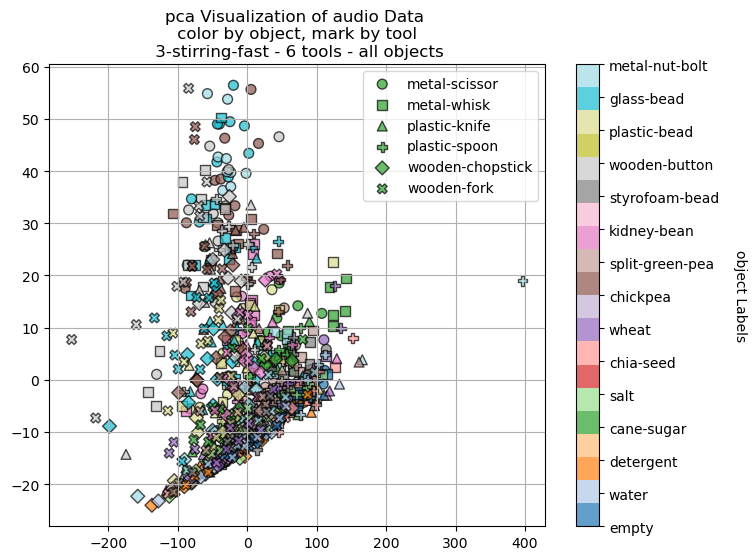

In [12]:
behaviors = ['3-stirring-fast']
visualize_in_2d(method="pca", color_by="object", mark_by="tool", robot_data=robot,
                tools=all_tools, object_list=all_object_list, behaviors=behaviors, modality=modality)

token data shape: (900, 100)
flattened token data shape: (900, 100)


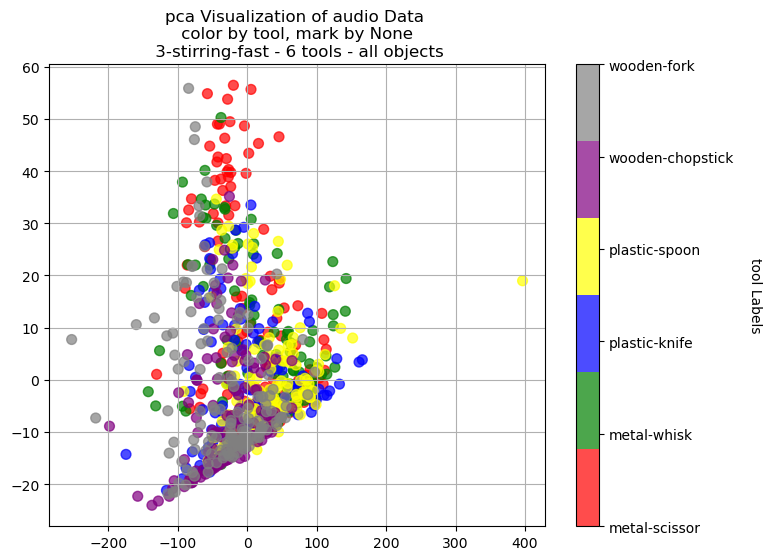

In [13]:
visualize_in_2d(method="pca", color_by="tool", robot_data=robot, 
                tools=all_tools, object_list=all_object_list, behaviors=behaviors, modality=modality)

token data shape: (5400, 100)
flattened token data shape: (5400, 100)


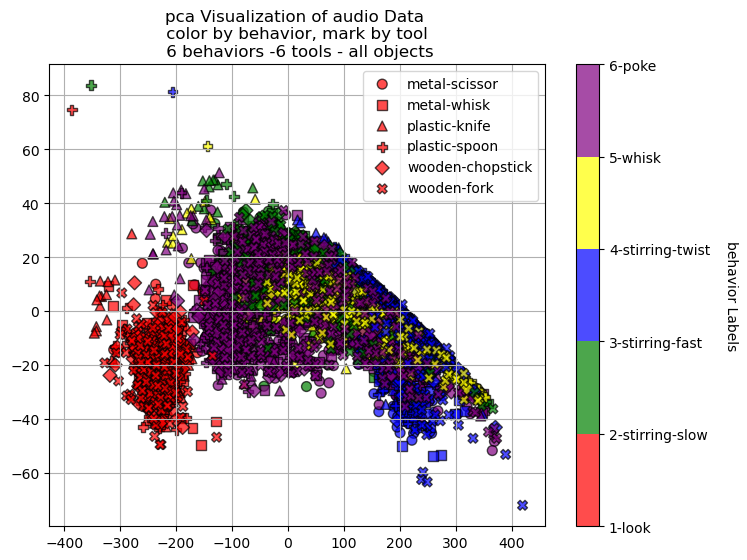

In [14]:
visualize_in_2d(method="pca", color_by="behavior", mark_by="tool", robot_data=robot, 
                tools=all_tools, object_list=all_object_list, behaviors=all_behaviors, modality=modality)

token data shape: (900, 100)
flattened token data shape: (900, 100)


/Users/siliu/opt/anaconda3/envs/ml135_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


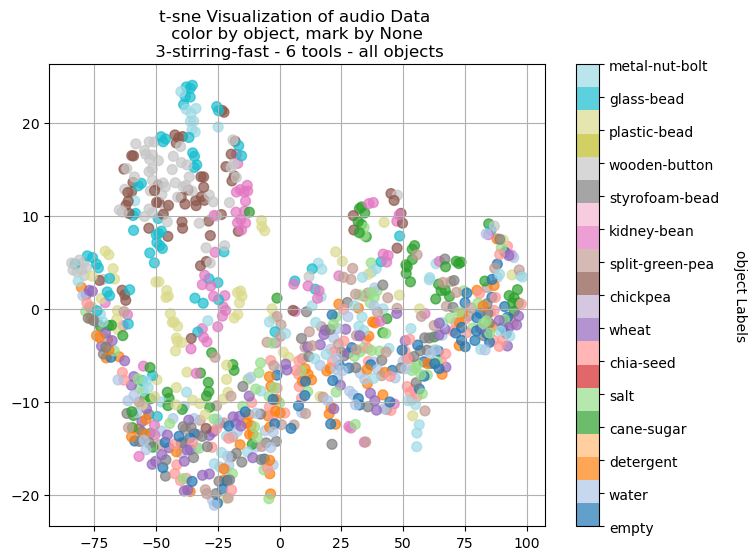

In [15]:
visualize_in_2d(method="t-sne", color_by="object", robot_data=robot, 
                tools=all_tools, object_list=all_object_list, behaviors=behaviors, modality=modality)

token data shape: (900, 100)
flattened token data shape: (900, 100)


/Users/siliu/opt/anaconda3/envs/ml135_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


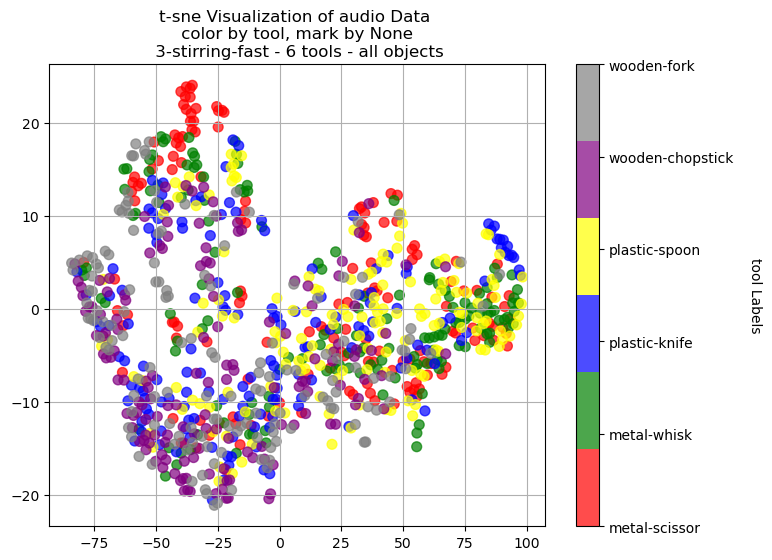

In [16]:
visualize_in_2d(method="t-sne", color_by="tool", robot_data=robot, 
                tools=all_tools, object_list=all_object_list, behaviors=behaviors, modality=modality)

token data shape: (900, 100)
flattened token data shape: (900, 100)


/Users/siliu/opt/anaconda3/envs/ml135_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


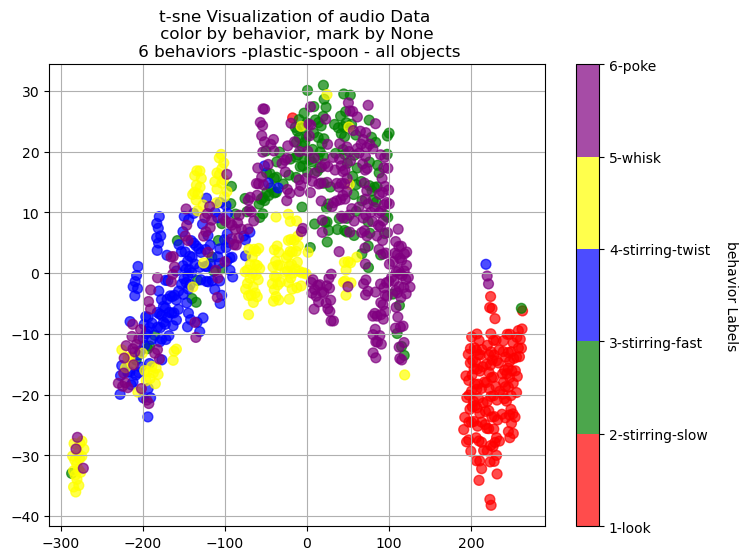

In [17]:
visualize_in_2d(method="t-sne", color_by="behavior", robot_data=robot, 
                tools=['plastic-spoon'], object_list=all_object_list, behaviors=all_behaviors, modality=modality)

token data shape: (5400, 100)
flattened token data shape: (5400, 100)


/Users/siliu/opt/anaconda3/envs/ml135_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


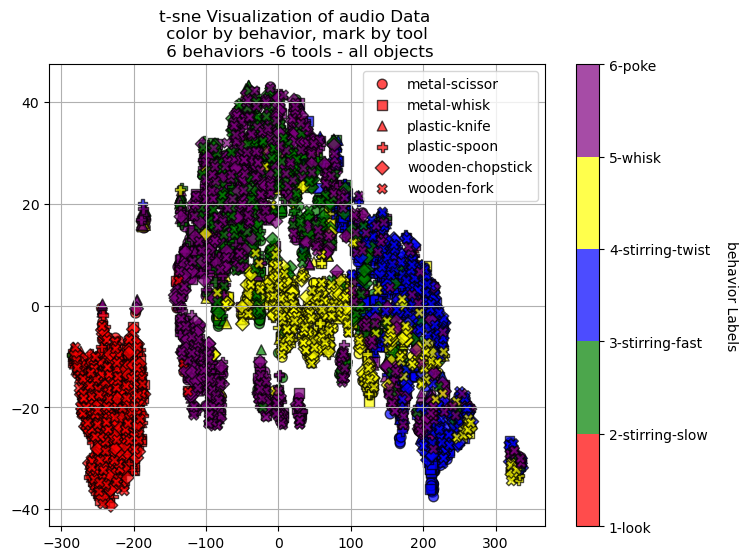

In [18]:
visualize_in_2d(method="t-sne", color_by="behavior", mark_by="tool", robot_data=robot, 
                tools=all_tools, object_list=all_object_list, behaviors=all_behaviors, modality=modality)

token data shape: (5400, 100)
flattened token data shape: (5400, 100)


/Users/siliu/opt/anaconda3/envs/ml135_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


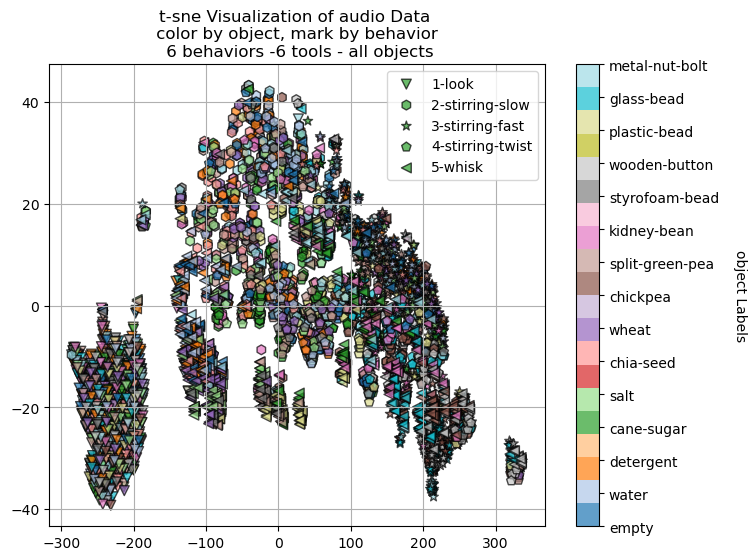

In [19]:
visualize_in_2d(method="t-sne", color_by="object", mark_by="behavior", robot_data=robot, 
                tools=all_tools, object_list=all_object_list, behaviors=all_behaviors, modality=modality)

token data shape: (900, 100)
flattened token data shape: (900, 100)


/Users/siliu/opt/anaconda3/envs/ml135_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


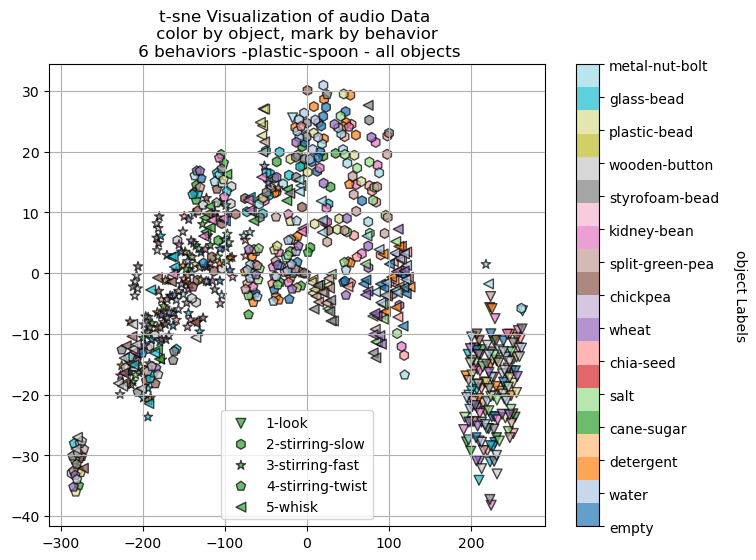

In [20]:
visualize_in_2d(method="t-sne", color_by="object", mark_by="behavior", robot_data=robot, 
                tools=['plastic-spoon'], object_list=all_object_list, behaviors=all_behaviors, modality=modality)

# BEATs embeddings

### viz

In [21]:
import os
import numpy as np
token_path = os.path.join('/Users/siliu/Documents/MulTransfer/audio_models/BEATS/unilm/beats', "audio_16kHz_token_data_trim_beh3.npz")
loaded = np.load(token_path)
X_array = loaded["array1"]
Y_array = loaded["array2"]
meta_data = loaded["array3"]

In [22]:
object_list = sorted(['cane-sugar', 'chia-seed', 'chickpea', 'detergent', 'empty',
               'glass-bead', 'kidney-bean', 'metal-nut-bolt', 'plastic-bead',
               'salt', 'split-green-pea', 'styrofoam-bead', 'water', 'wheat',
               'wooden-button'])
behaviors = ['3-stirring-fast']
all_tools = ['metal-scissor', 'metal-whisk', 'plastic-knife', 'plastic-spoon', 'wooden-chopstick', 'wooden-fork']

robot = {beh: {tool: {"audio": {obj: {"X": [], "Y": []} for obj in object_list}} for tool in all_tools} for beh in behaviors}
for b_idx, b in enumerate(behaviors):
    for t_idx, t in enumerate(all_tools):
        for o_idx, o in enumerate(object_list):
            obj_relevant_idx = b_idx*len(all_tools)*len(object_list)*10 + t_idx*len(object_list)*10 + (o_idx*10)
            assert (meta_data[obj_relevant_idx] == [b, t, o]).all()
            robot[b][t]['audio'][o]['X'] = X_array[obj_relevant_idx: obj_relevant_idx+10]
            robot[b][t]['audio'][o]['Y'] = Y_array[obj_relevant_idx: obj_relevant_idx+10]

In [23]:
robot[b][t]['audio']['wooden-button']['Y']

array([[14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14]])

token data shape: (900, 992, 768)
flattened token data shape: (900, 761856)


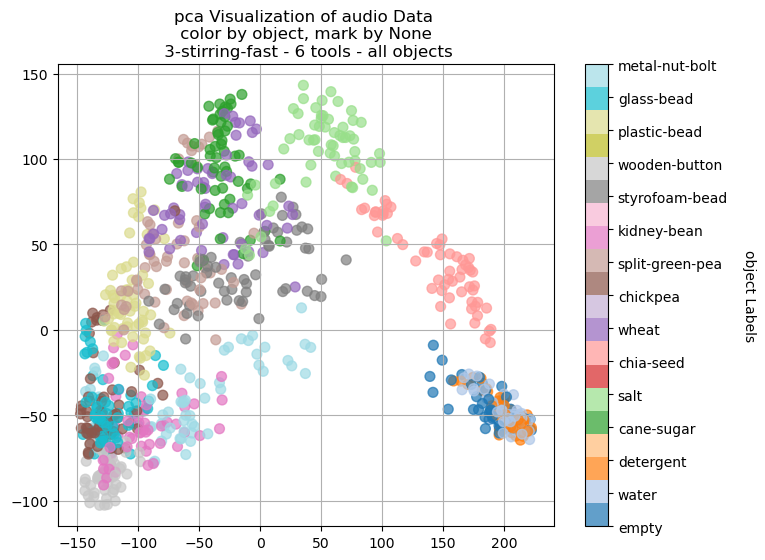

In [24]:
visualize_in_2d(method="pca", color_by="object", robot_data=robot, token_dim=None,
                tools=all_tools, object_list=all_object_list, behaviors=behaviors, modality=modality)

token data shape: (900, 992, 768)
flattened token data shape: (900, 761856)


/Users/siliu/opt/anaconda3/envs/ml135_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


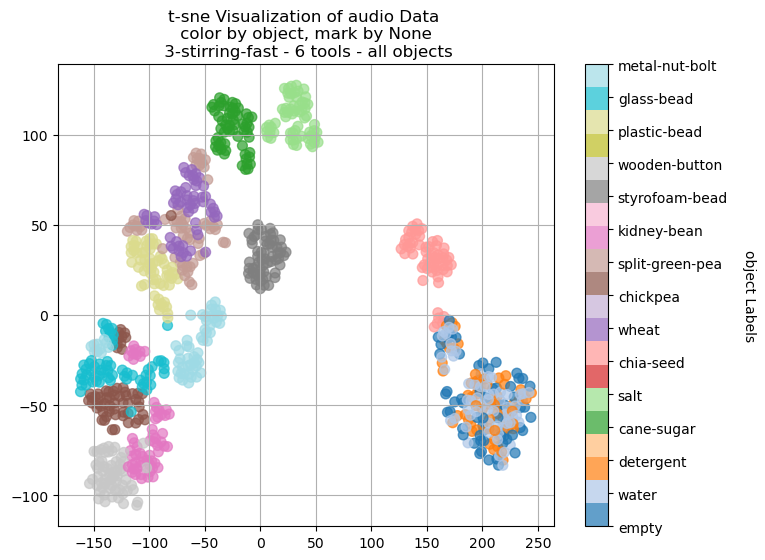

In [25]:
visualize_in_2d(method="t-sne", color_by="object", robot_data=robot, token_dim=None,
                tools=all_tools, object_list=all_object_list, behaviors=behaviors, modality=modality)

### downsize token by 32 and save it

In [26]:
down_ratio = 32

robot_down_size = {beh: {tool: {"audio": {obj: {"X": [], "Y": []} for obj in object_list}} for tool in all_tools} for beh in behaviors}
for b_idx, b in enumerate(behaviors):
    for t_idx, t in enumerate(all_tools):
        for o_idx, o in enumerate(object_list):
            obj_relevant_idx = b_idx*len(all_tools)*len(object_list)*10 + t_idx*len(object_list)*10 + (o_idx*10)
            assert (meta_data[obj_relevant_idx] == [b, t, o]).all()
            trial_batch_x = copy.deepcopy(X_array[obj_relevant_idx: obj_relevant_idx+10])
            trial_batch_x = np.array([resize(x, (x.shape[0] // down_ratio, x.shape[1] // down_ratio), anti_aliasing=True) 
                                             for x in trial_batch_x])
            robot_down_size[b][t]['audio'][o]['X'] = trial_batch_x.reshape(len(trial_batch_x), -1)
            robot_down_size[b][t]['audio'][o]['Y'] = Y_array[obj_relevant_idx: obj_relevant_idx+10]

token data shape: (900, 744)
flattened token data shape: (900, 744)


/Users/siliu/opt/anaconda3/envs/ml135_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


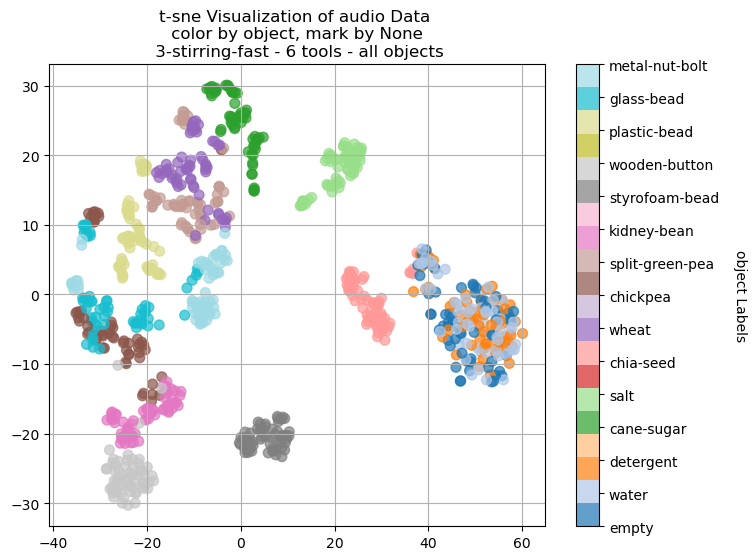

In [27]:
visualize_in_2d(method="t-sne", color_by="object", robot_data=robot_down_size, token_dim=None,
                tools=all_tools, object_list=all_object_list, behaviors=behaviors, modality=modality)

In [28]:
robot_down_size[all_behaviors[2]][all_tools[0]]['audio'][all_object_list[0]]['X'].shape, robot_down_size[all_behaviors[2]][all_tools[0]]['audio'][all_object_list[0]]['Y'].shape

((10, 744), (10, 1))

In [29]:
import pickle
# Pickle files are Python-specific
with open('audio_16kHz_token_down16_beh3.bin', 'wb') as file:
    pickle.dump(robot_down_size, file)
print("Dictionary saved to audio_16kHz_token_down16_beh3.bin")

Dictionary saved to audio_16kHz_token_down16_beh3.bin


### sanity check data parsing 

In [30]:
data_file = "audio_16kHz_token_down16_beh3.bin"
bin_file = open(data_file, 'rb')
robot = pickle.load(bin_file)
bin_file.close()

robot_down_size1 = {beh: {tool: {"audio": {obj: {"X": [], "Y": []} for obj in object_list}} for tool in all_tools} for beh in behaviors}
for b_idx, b in enumerate(behaviors):
    for t_idx, t in enumerate(all_tools):
        for o_idx, o in enumerate(object_list):
            trial_batch_x = copy.deepcopy(robot_down_size[b][t]['audio'][o]['X'])
            trial_batch_x = trial_batch_x.reshape(10, 31, 24)
            robot_down_size1[b][t]['audio'][o]['X'] = trial_batch_x
            robot_down_size1[b][t]['audio'][o]['Y'] = robot_down_size[b][t]['audio'][o]['Y']

token data shape: (900, 744)
flattened token data shape: (900, 744)


/Users/siliu/opt/anaconda3/envs/ml135_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


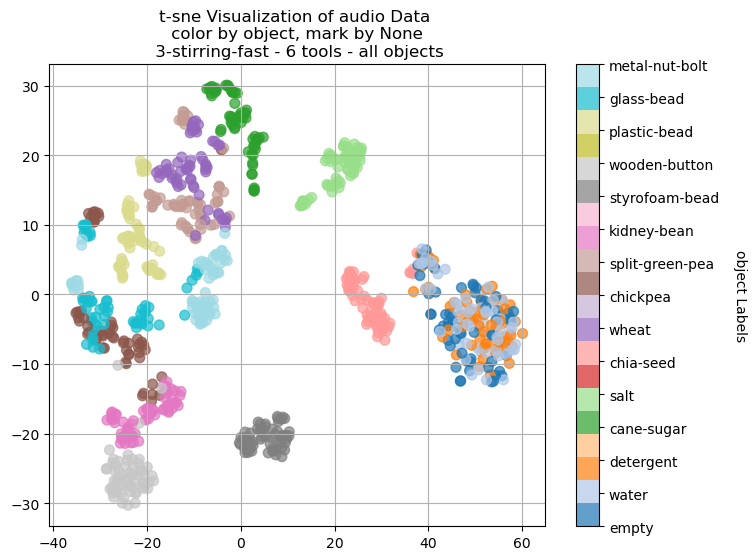

In [31]:
visualize_in_2d(method="t-sne", color_by="object", robot_data=robot, token_dim=None, down_ratio=None,
                tools=all_tools, object_list=all_object_list, behaviors=behaviors, modality=modality)

In [21]:
import numpy as np
trial_list = [0,1,2,3,4,5,6]
num_trials_to_sample = 2
l = np.random.choice(trial_list, size=num_trials_to_sample, replace=False)
print(l)

[5 3]
